In [ ]:
import h5py

with h5py.File("fused_features.h5", "r") as f:
    X_train_fused = f["X_train"][:]
    X_val_fused = f["X_val"][:]
    X_test_fused = f["X_test"][:]

print("Extracted fused features loaded from HDF5!")

Extracted fused features loaded from HDF5!


In [ ]:
import numpy as np
with h5py.File('labels.h5', 'r') as f:
    y_encoded = np.array(f['y_encoded'])
    class_names = np.array(f['classes']).astype(str)

print("Loaded Encoded Labels:", y_encoded)
print("Class Names:", class_names)


Loaded Encoded Labels: [1 1 1 ... 3 3 3]
Class Names: ['bacterial_leaf_blight' 'brown_spot' 'healthy' 'leaf_blast' 'leaf_scald'
 'narrow_brown_spot' 'neck_blast' 'rice_hispa' 'sheath_blight' 'tungro']


In [ ]:
with h5py.File("labels.h5", "r") as f:
    y_train = f["y_train"][:]
    y_val = f["y_val"][:]
    y_test = f["y_test"][:]

print("Labels loaded successfully from HDF5!")


Labels loaded successfully from HDF5!


In [ ]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

num_classes = len(np.unique(y_encoded))

classifier = Sequential([
    Dense(1024, activation='relu', input_shape=(X_train_fused.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')
])

classifier.compile(optimizer=Adam(learning_rate=0.001),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

classifier.summary()

2025-04-01 16:23:19.592014: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-01 16:23:19.592040: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-01 16:23:19.592987: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-01 16:23:19.614634: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-01 16:23:20.375114: W tensorflow/compiler/tf2

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 512)               0

2025-04-01 16:23:21.072825: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-01 16:23:21.110266: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [ ]:
early_stopping = EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)

callbacks = [early_stopping, reduce_lr]

In [ ]:
history = classifier.fit(
    X_train_fused, y_train,
    validation_data=(X_val_fused, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/100
376/376 [==============================] - 4s 11ms/step - loss: 0.1294 - accuracy: 0.9552 - val_loss: 0.2288 - val_accuracy: 0.9268 - lr: 4.8828e-07
Epoch 2/100
376/376 [==============================] - 4s 11ms/step - loss: 0.1282 - accuracy: 0.9541 - val_loss: 0.2288 - val_accuracy: 0.9261 - lr: 4.8828e-07
Epoch 3/100
376/376 [==============================] - 4s 11ms/step - loss: 0.1293 - accuracy: 0.9535 - val_loss: 0.2292 - val_accuracy: 0.9254 - lr: 4.8828e-07
Epoch 4/100
376/376 [==============================] - ETA: 0s - loss: 0.1368 - accuracy: 0.9522
Epoch 4: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.
376/376 [==============================] - 4s 11ms/step - loss: 0.1368 - accuracy: 0.9522 - val_loss: 0.2300 - val_accuracy: 0.9261 - lr: 4.8828e-07
Epoch 5/100
376/376 [==============================] - 4s 11ms/step - loss: 0.1305 - accuracy: 0.9547 - val_loss: 0.2290 - val_accuracy: 0.9261 - lr: 2.4414e-07
Epoch 6/100
376/376 [============

In [ ]:
test_loss, test_acc = classifier.evaluate(X_test_fused, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

47/47 [==============================] - 0s 2ms/step - loss: 0.1792 - accuracy: 0.9441
Test Accuracy: 94.41%


47/47 [==============================] - 0s 2ms/step
[[125   0   0   0   0   0   0   0   0   1]
 [  0 132   1   4   0   1   0   1   0   0]
 [  0   3 151   4   0   0   0   3   0   1]
 [  0   5   4 166   1   1   0   0   2   2]
 [  0   0   0   3 157   3   0   2   5   0]
 [  0   0   2   9   2 114   0   3   3   0]
 [  0   0   0   0   0   0  92   0   0   0]
 [  0   0   1   0   2   1   0 144   1   0]
 [  0   1   1   2   2   0   0   1 155   2]
 [  0   1   0   1   0   0   0   1   1 183]]


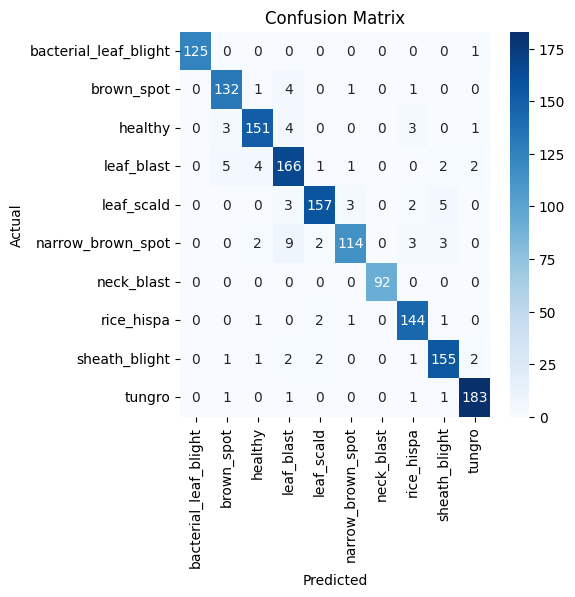

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = classifier.predict(X_test_fused)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_classes)
print(cm)

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_classes))


              precision    recall  f1-score   support

           0       1.00      0.99      1.00       126
           1       0.92      0.95      0.94       139
           2       0.95      0.93      0.94       162
           3       0.88      0.92      0.90       181
           4       0.96      0.92      0.94       170
           5       0.95      0.86      0.90       133
           6       1.00      1.00      1.00        92
           7       0.93      0.97      0.95       149
           8       0.93      0.95      0.94       164
           9       0.97      0.98      0.97       187

    accuracy                           0.94      1503
   macro avg       0.95      0.95      0.95      1503
weighted avg       0.94      0.94      0.94      1503



In [ ]:
classifier.save("classifier.keras")

In [ ]:
from tensorflow import keras

model = keras.models.load_model("classifier.keras")

model.summary()


2025-04-05 16:36:48.233406: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-05 16:36:48.233596: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-05 16:36:48.428941: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-05 16:36:49.055869: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-05 16:36:52.503163: W tensorflow/compiler/tf2

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 512)               0